# Laboratorium 3

### Konfiguracja

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random
import math
import functools
import time

new_added_points = []

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw()
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                new_added_points.append( [(self.new_line_point[0], self.new_line_point[1]), (new_point[0], new_point[1]) ] )
                self.new_line_point = None
                self.draw()
            else:
                self.new_line_point = new_point


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [85]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [], json = None):
        new_added_points = []
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])

    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    def draw(self):
        plt.close('all')
        fig = plt.figure()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        ax = plt.axes()
        callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', callback.on_click)
        plt.show()
        callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


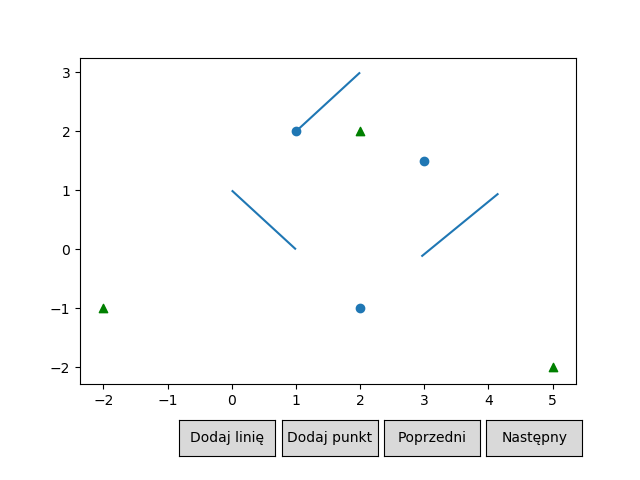

In [51]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))
plot.draw() 


In [53]:
new_added_points

[[(2.95550591924044, -0.12049241115477649),
  (4.155440892326376, 0.9475676673409312)]]

###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

In [ ]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

### Rozwiązanie

<IPython.core.display.Javascript object>


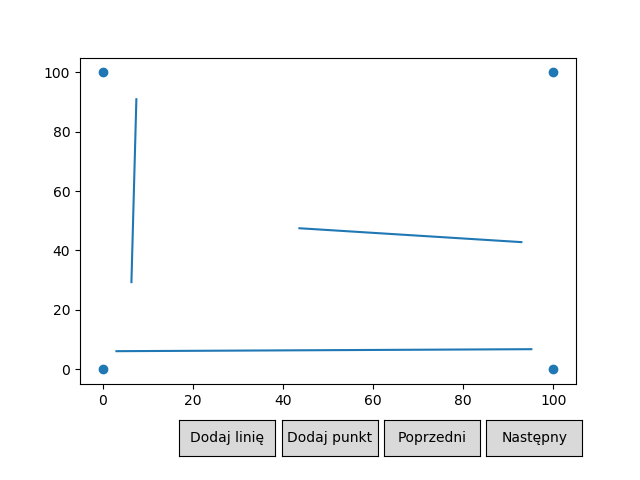

In [110]:
%matplotlib notebook
#new_added_points = []
scenes=[Scene([PointsCollection([(0,0),(0,100),(100,0),(100,100)])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))
plot.draw() 



In [136]:
new_added_points = []

In [153]:
def gen_lines(num):
    xMax = 100
    yMax = 100
    for _ in range(num):
        new_added_points.append( [(int(random.uniform(0, xMax)), int(random.uniform(0, yMax)))
                                  , (int(random.uniform(0, xMax)), int(random.uniform(0, yMax))) ] )
        
def get_all_lines():
    return LinesCollection(new_added_points)

EPS = 10**(-13)

def orient(a, b, c):
    arr = np.array([ [a[0] - c[0], a[1] - c[1]], [b[0]-c[0], b[1]-c[1]] ])
    det = np.linalg.det(arr)
    #print("det", det)
    if det-EPS > 0: return 1
    elif det+EPS < 0: return -1
    else: return 0
    
def intersect(a1, a2, b1, b2) :
    o1 = orient( a1 , a2 , b1 )
    o2 = orient( a1 , a2 , b2 )
    o3 = orient( b1 , b2 , a1 )
    o4 = orient( b1 , b2 , a2 )
    if ( o1 != o2 ) and ( o3 != o4 ) :
        return True
    else:
        return False
    
"""
http://www.izdebski.edu.pl/kategorie/Informatyka/Cwiczenie_02.pdf
x_p = a1.x + t * dX_a1_a2
y_p = a1.y + t * dY_a1_a2

    dX_a1_b1 * dY_b1_b2 - dY_a1_b1 * dX_b1_b2
t = -----------------------------------------
    dX_a1_a2 * dY_b1_b2 - dY_a1_a2 * dX_b1_b2
    
"""
def dX(a, b): return b[0] - a[0]
def dY(a, b): return b[1] - a[1]
def intersect_point(a1, a2, b1, b2):
    dX_a1_a2 = dX(a1, a2)
    dY_a1_a2 = dY(a1, a2)
    
    dX_a1_b1 = dX(a1, b1)
    dY_b1_b2 = dY(b1, b2)
    dY_a1_b1 = dY(a1, b1)
    dX_b1_b2 = dX(b1, b2)
    
    dX_a1_a2 = dX(a1, a2)
    dY_b1_b2 = dY(b1, b2)
    dY_a1_a2 = dY(a1, a2)
    dX_b1_b2 = dX(b1, b2)
    
    t = (dX_a1_b1 * dY_b1_b2 - dY_a1_b1 * dX_b1_b2) / (dX_a1_a2 * dY_b1_b2 - dY_a1_a2 * dX_b1_b2)
    
    return (a1[0] + t * dX_a1_a2, a1[1] + t * dY_a1_a2)

In [138]:
gen_lines(10)

<IPython.core.display.Javascript object>


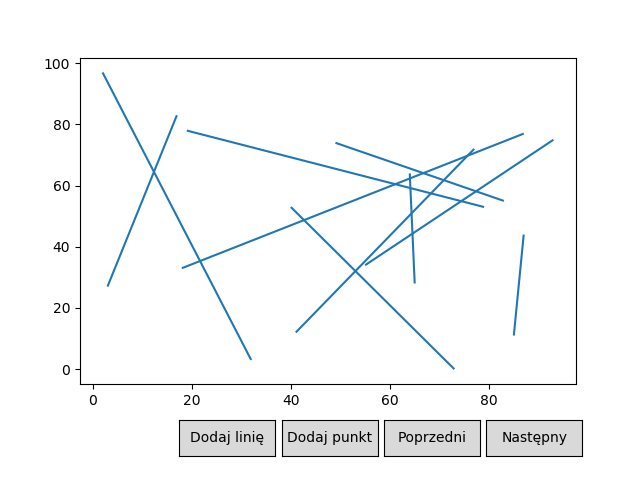

In [139]:
%matplotlib notebook

scenes=[Scene([], [get_all_lines()])]

plot = Plot(scenes)
plot.draw() 

In [161]:

def sweep():
    maxY = 100
    action_points_X = sorted([line[0][0] for line in new_added_points] + [line[1][0] for line in new_added_points])
    intersection_points_list = []
    # iteracja
    for mX in action_points_X:
        lines_list = new_added_points
        cross_lines = []
        for line in lines_list:
            if(intersect(line[0], line[1], (mX, 0), (mX, maxY)) and max(line[0][0], line[1][0]) != mX):
                cross_lines.append(line)

        def keyFun(line):
            return intersect_point(line[0], line[1], (mX, 0), (mX, maxY))
        sorted_cross_lines = sorted(cross_lines, key=keyFun)
        
        for i, line_A in enumerate(sorted_cross_lines[:-1]):
            line_B = sorted_cross_lines[i+1];
            if(intersect(line_A[0], line_A[1], line_B[0], line_B[1])):
                intersection_points_list.append(intersect_point(line_A[0], line_A[1], line_B[0], line_B[1]))
    return  intersection_points_list
    

sweep()

[(12.373831775700936, 64.49532710280374),
 (21.6771714066103, 35.344862925954395),
 (21.6771714066103, 35.344862925954395),
 (61.07560137457045, 60.468499427262316),
 (42.66118614210217, 48.7259737717753),
 (75.66197183098592, 69.7699530516432),
 (42.66118614210217, 48.7259737717753),
 (53.03703703703704, 32.06172839506173),
 (42.661186142102174, 48.7259737717753),
 (61.07560137457045, 60.468499427262316),
 (75.66197183098592, 69.7699530516432),
 (61.07560137457045, 60.468499427262316),
 (68.28, 57.46666666666667),
 (61.07560137457045, 60.468499427262316),
 (64.04549050632912, 62.36234177215189),
 (68.28, 57.46666666666667),
 (61.07560137457045, 60.468499427262316),
 (66.74492340577129, 64.08371927324546),
 (74.3900293255132, 54.9208211143695),
 (70.86784140969164, 61.779735682819386),
 (75.66197183098592, 69.7699530516432),
 (74.3900293255132, 54.9208211143695),
 (77.37618147448015, 58.14272211720227),
 (66.74492340577129, 64.08371927324546),
 (77.37618147448015, 58.14272211720227)]

<IPython.core.display.Javascript object>


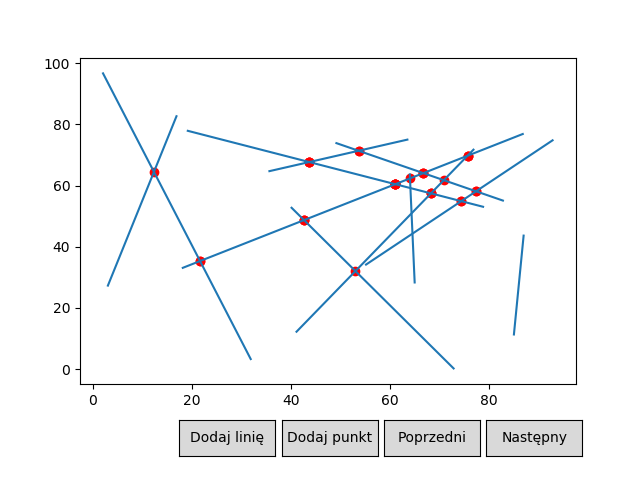

In [163]:
%matplotlib notebook

scenes=[Scene([PointsCollection(sweep(), color="red")], [get_all_lines()])]

plot = Plot(scenes)
plot.draw() 